# **Modelagem com machine learning**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, matthews_corrcoef, roc_curve, confusion_matrix
from IPython.display import display
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings('ignore')

# Carrega os dados do arquivo da etapa anterior
file_path = '../data/df_eng.csv'
df = pd.read_csv(file_path, sep=';', encoding='iso-8859-1')
df = df[df['faltou'] == 0] # Remove candidatos que faltaram a alguma prova, pois não faz sentido usá-los para prever a nota. Uma ideia futura é criar um modelo para prever abstenções
df

,faixa_etaria,escolaridade_mae,tamanho_familia,renda_familiar,sexo_feminino,escola_privada,treineiro,faltou,branco_amarelo,preto_pardo_indigena,possui_computador,media_objetivas_alta,nota_redacao_alta,media_geral_alta
2,3,2,2,1,1,0,0,0,0,1,0,0,0,0
3,4,5,3,16,0,0,0,0,0,1,1,0,0,0
7,4,4,5,1,1,0,0,0,0,1,0,0,0,0
9,2,4,2,1,1,0,0,0,0,1,0,0,0,0
11,0,4,4,1,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476098,10,4,4,2,0,0,0,0,1,0,0,0,0,0
3476100,9,0,1,3,1,0,0,0,0,1,1,0,0,0
3476101,0,4,2,1,0,0,0,0,0,1,0,0,0,0
3476102,9,6,3,1,1,0,0,0,1,0,0,0,0,0


In [11]:
# Utiliza uma amostragem aleatória de 20% dos dados originais para treino e validação do modelo
max_candidatos = df.shape[0] // 5

df_amostra = df.sample(n=max_candidatos, random_state=111) # Seleciona a amostra aleatória
df_restante = df.drop(df_amostra.index)                    # Remove os selecionados para formar o restante
del df

print(f'Tamanho da amostra utilizada para treino e validação: {max_candidatos}')

Tamanho da amostra utilizada para treino e validação: 468965


## **Variáveis consideradas**

+ **'faixa_etaria'** - idade do candidato, categorizada por faixas etárias.
+ **'escolaridade_mae'** - grau de escolaridade da mãe do candidato, representado em categorias.
+ **'tamanho_familia'** - número de membros na mesma residência do candidato.
+ **'renda_familiar'** - faixa de renda familiar declarada pelo candidato.
+ **'sexo_feminino'** - indica se o candidato é do sexo feminino (1 = sim, 0 = não).
+ **'escola_privada'** - indica se o candidato frequentou escola privada no ensino médio (1 = sim, 0 = não).
+ **'treineiro'** - indica se o candidato fez a prova apenas como treino (1 = sim, 0 = não).
+ **'branco_amarelo'** - indica se o candidato se autodeclara branco ou amarelo (1 = sim, 0 = não).
+ **'preto_pardo_indigena'** - indica se o candidato se autodeclara preto, pardo ou indígena (1 = sim, 0 = não).
+ **'possui_computador'** - indica se o candidato declarou possuir um computador em casa (1 = sim, 0 = não).
#
**Variável alvo** - optou-se por escolher apenas a **média das questões objetivas** como variável alvo, pois a nota de redação apresenta uma significativa probabilidade de ser zerada, independente de questões socioeconômicas. Lembrando que, na etapa anterior, foi considerada uma média alta se ela ultrapassou a média de todos os candidatos mais um desvio padrão (**> 593,73**).

## **Balanceamento de classes**

In [3]:
# Define a variável alvo e as features
X = df_amostra.drop(columns=['media_objetivas_alta', 'nota_redacao_alta', 'media_geral_alta', 'faltou'])
y = df_amostra['media_objetivas_alta']

# Divide os dados em treino (80%) e validação (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111, stratify=y)

# Verifica o balanceamento das classes
class_distribution = y_train.value_counts(normalize=True)
print('Distribuição das classes antes do balanceamento:')
print(class_distribution)

# Se houver desbalanceamento, aplica o oversampling (SMOTE) ou undersampling
threshold = 0.4 # Se uma classe tiver menos de 40% dos exemplos, considera desbalanceado

min_class_ratio = class_distribution.min()

if min_class_ratio < threshold:
    print('\nAplicando balanceamento com SMOTE...')
    smote = SMOTE(random_state=111)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
else:
    print('\nAplicando balanceamento com undersampling...')
    undersample = RandomUnderSampler(random_state=111)
    X_train_bal, y_train_bal = undersample.fit_resample(X_train, y_train)

# Verifica a nova distribuição das classes
new_class_distribution = pd.Series(y_train_bal).value_counts(normalize=True)
print('Distribuição das classes após o balanceamento:')
print(new_class_distribution)

Distribuição das classes antes do balanceamento:
0    0.833223
1    0.166777
Name: media_objetivas_alta, dtype: float64

Aplicando balanceamento com SMOTE...
Distribuição das classes após o balanceamento:
0    0.5
1    0.5
Name: media_objetivas_alta, dtype: float64


## **Treinamento e validação do modelo em uma amostra do dataset original (aproximadamente 470.000 linhas)**

Para o treinamento, optou-se por utilizar modelos baseados em árvores, pois eles apresentam algumas vantagens:

+ Convergem rápido
+ Não precisam de scalers
+ Lidam bem com dados tabulares e relações não lineares
+ São robustos contra outliers

Métricas consideradas:

+ **AUC-ROC:** mede a capacidade do modelo de distinguir entre as classes. Vai de 0 a 1, e quanto maior o valor, melhor a separação entre positivos e negativos.
+ **MCC (Matthews correlation coefficient):** mede a correlação entre as previsões e os valores reais. Varia de -1 a 1. O MCC considera todos os quatro elementos da matriz de confusão, diferente de outras métricas como accuracy, precision, recall e F1-score, que utilizam no máximo três. Por isso, ele é um bom indicador de desempenho geral do modelo em problemas de classificação, especialmente se houverem classes desbalanceadas.


Random Forest:
AUC-ROC: 0.7062
MCC: 0.3263


,precision,recall,f1-score,support
0,0.919051,0.736408,0.817654,78151.000000
1,0.339172,0.675937,0.451693,15642.000000
accuracy,0.726323,0.726323,0.726323,0.726323
macro avg,0.629112,0.706172,0.634674,93793.000000
weighted avg,0.822344,0.726323,0.756622,93793.000000


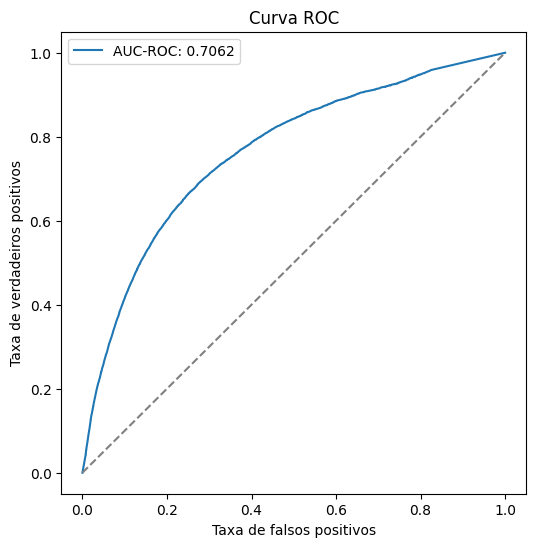

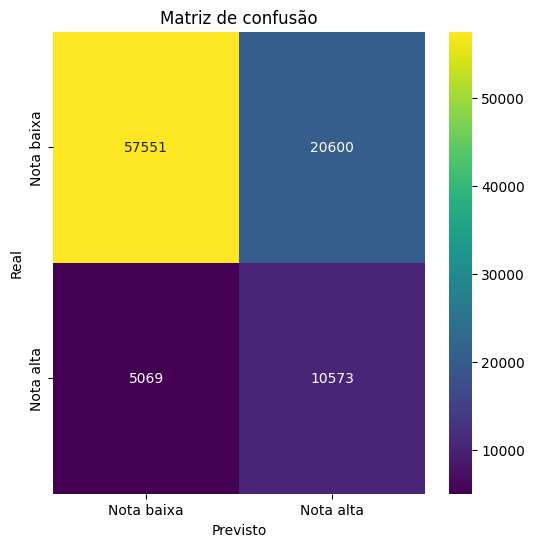


XGBoost:
AUC-ROC: 0.7418
MCC: 0.3775


,precision,recall,f1-score,support
0,0.936940,0.728717,0.819814,78151.000000
1,0.357740,0.754955,0.485448,15642.000000
accuracy,0.733093,0.733093,0.733093,0.733093
macro avg,0.647340,0.741836,0.652631,93793.000000
weighted avg,0.840346,0.733093,0.764051,93793.000000


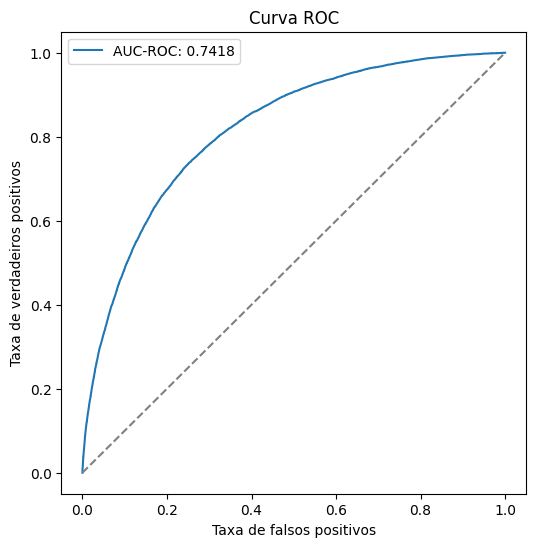

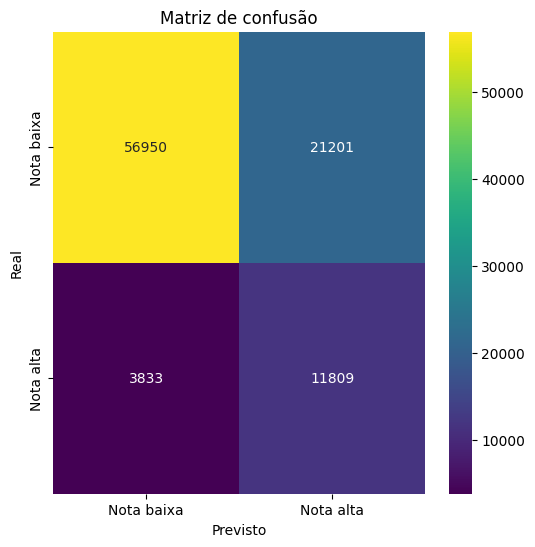

Melhores hiperparâmetros do XGBoost:
{'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 200}

XGBoost Otimizado:
AUC-ROC: 0.7305
MCC: 0.3621


,precision,recall,f1-score,support
0,0.930656,0.734322,0.820913,78151.00000
1,0.353761,0.726633,0.475854,15642.00000
accuracy,0.733040,0.733040,0.733040,0.73304
macro avg,0.642209,0.730478,0.648383,93793.00000
weighted avg,0.834447,0.733040,0.763367,93793.00000


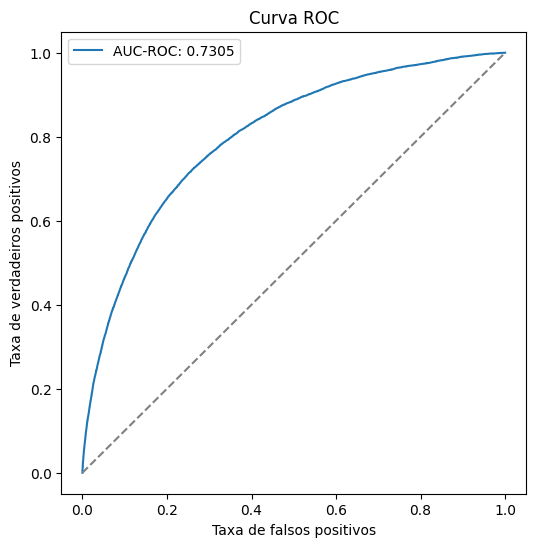

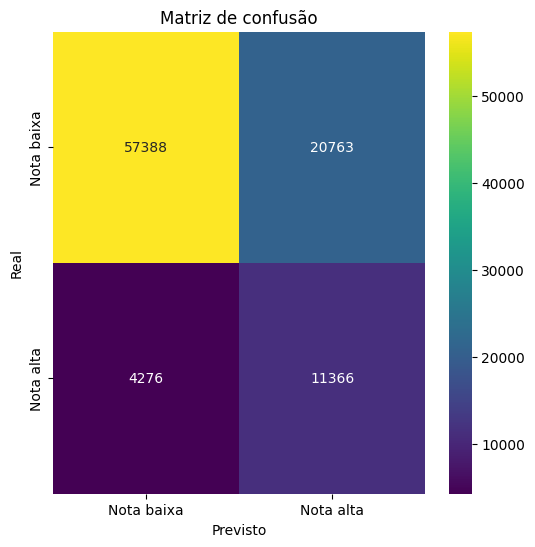

O melhor modelo em AUC-ROC foi: XGBoost com 0.7418
O melhor modelo em MCC foi: XGBoost com 0.3775
Importância das features:


,Feature,Importance
9,possui_computador,0.627717
6,treineiro,0.082487
3,renda_familiar,0.079968
8,preto_pardo_indigena,0.049846
4,sexo_feminino,0.042371
5,escola_privada,0.037951
1,escolaridade_mae,0.023825
0,faixa_etaria,0.023124
2,tamanho_familia,0.019232
7,branco_amarelo,0.013478


In [4]:
# Função para treinar, avaliar e gerar gráficos dos modelos
def avaliar_modelo(modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] # Probabilidades para a curva ROC

    # Calcula AUC-ROC
    auc = roc_auc_score(y_test, y_pred)
    print(f'AUC-ROC: {auc:.4f}')

    # Calcula MCC
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f'MCC: {mcc:.4f}')

    # Converte o classification report em um dataframe
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Exibe o dataframe com as métricas
    display(report_df)

    # Plota a curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC-ROC: {auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Taxa de falsos positivos')
    plt.ylabel('Taxa de verdadeiros positivos')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

    # Plota a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Nota baixa', 'Nota alta'], yticklabels=['Nota baixa', 'Nota alta'])
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()

    return auc, mcc

# Treina o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=111)
print('\nRandom Forest:')
auc_rf, mcc_rf = avaliar_modelo(rf, X_train_bal, X_test, y_train_bal, y_test)

# Treina o modelo XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111)
print('\nXGBoost:')
auc_xgb, mcc_xgb = avaliar_modelo(xgb_model, X_train_bal, X_test, y_train_bal, y_test)

# Otimiza hiperparâmetros do XGBoost com grid search e 5-fold CV
param_grid_xgb = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111),
                               param_grid_xgb, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search_xgb.fit(X_train_bal, y_train_bal)

print('Melhores hiperparâmetros do XGBoost:')
print(grid_search_xgb.best_params_)

print('\nXGBoost Otimizado:')
auc_xgb_opt, mcc_xgb_opt = avaliar_modelo(grid_search_xgb.best_estimator_, X_train_bal, X_test, y_train_bal, y_test)

# Compara os modelos
resultados_auc = {
    'Random Forest': auc_rf,
    'XGBoost': auc_xgb,
    'XGBoost Otimizado': auc_xgb_opt
}

resultados_mcc = {
    'Random Forest': mcc_rf,
    'XGBoost': mcc_xgb,
    'XGBoost Otimizado': mcc_xgb_opt
}

melhor_modelo_auc = max(resultados_auc, key=resultados_auc.get)
melhor_modelo_mcc = max(resultados_mcc, key=resultados_mcc.get)

print(f'O melhor modelo em AUC-ROC foi: {melhor_modelo_auc} com {resultados_auc[melhor_modelo_auc]:.4f}')
print(f'O melhor modelo em MCC foi: {melhor_modelo_mcc} com {resultados_mcc[melhor_modelo_mcc]:.4f}')

# Analisa a importância das features do melhor modelo baseado em AUC-ROC
importances = grid_search_xgb.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print('Importância das features:')
display(feature_importance)

**Análise da Importância das Features**

+ A variável **"possui_computador"** apresentou a maior importância no modelo, indicando que o acesso a um computador pode estar fortemente correlacionado com um melhor desempenho nas questões objetivas.

+ Outras variáveis como **"treineiro"**, **"renda_familiar"** e **"preto_pardo_indigena"** também possuem contribuições relevantes, sugerindo que fatores socioeconômicos e características individuais desempenham um papel na previsão da nota.

+ Variáveis como **"branco_amarelo"**, **"tamanho_familia"** e **"faixa_etaria"** tiveram menor importância, sugerindo que seu impacto no modelo foi mais limitado.

+ A análise da importância das variáveis pode ser útil para interpretar quais fatores estão mais associados ao desempenho, mas não implica causalidade.

## **Teste nos 80% restantes do dataset original (aproximadamente 1.9 milhão de linhas)**

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=111, ...)

Desempenho do melhor modelo em dados desconhecidos:
AUC-ROC: 0.7435
MCC: 0.3805


,precision,recall,f1-score,support
0,0.937484,0.728674,0.819995,1.561816e+06
1,0.359795,0.758344,0.488040,3.140450e+05
accuracy,0.733641,0.733641,0.733641,7.336412e-01
macro avg,0.648640,0.743509,0.654018,1.875861e+06
weighted avg,0.840771,0.733641,0.764421,1.875861e+06


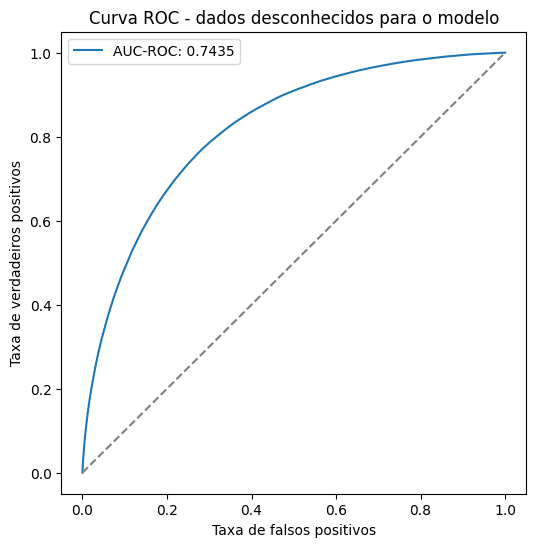

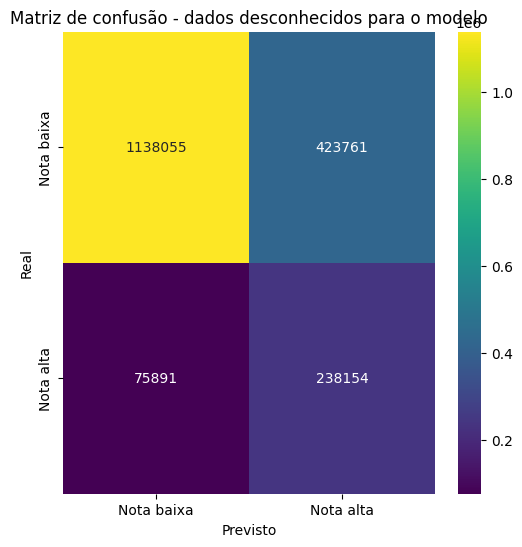

In [ ]:
# Obtém o melhor modelo com base no AUC-ROC
melhor_modelo = (
    rf if melhor_modelo_auc == 'Random Forest' else
    xgb_model if melhor_modelo_auc == 'XGBoost' else
    grid_search_xgb.best_estimator_
)
print(melhor_modelo)

# Prepara os dados de entrada para a previsão no df_restante
X_restante = df_restante.drop(columns=['media_objetivas_alta', 'nota_redacao_alta', 'media_geral_alta', 'faltou'])
y_restante = df_restante['media_objetivas_alta']

# Faz previsões com o melhor modelo selecionado
y_pred_restante = melhor_modelo.predict(X_restante)
y_proba_restante = melhor_modelo.predict_proba(X_restante)[:, 1] # Probabilidades para a curva ROC

# Avalia o desempenho nos dados totalmente desconhecidos
auc_restante = roc_auc_score(y_restante, y_pred_restante)
mcc_restante = matthews_corrcoef(y_restante, y_pred_restante)

print('\nDesempenho do melhor modelo em dados desconhecidos:')
print(f'AUC-ROC: {auc_restante:.4f}')
print(f'MCC: {mcc_restante:.4f}')

# Converte o classification report em um dataframe
report_dict_restante = classification_report(y_restante, y_pred_restante, output_dict=True)
report_df_restante = pd.DataFrame(report_dict_restante).transpose()

# Exibe o dataframe com as métricas
display(report_df_restante)

# Plota a curva ROC
fpr_restante, tpr_restante, _ = roc_curve(y_restante, y_proba_restante)
plt.figure(figsize=(6, 6))
plt.plot(fpr_restante, tpr_restante, label=f'AUC-ROC: {auc_restante:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de verdadeiros positivos')
plt.title('Curva ROC - dados desconhecidos para o modelo')
plt.legend()
plt.show()

# Plota a matriz de confusão
cm_restante = confusion_matrix(y_restante, y_pred_restante)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_restante, annot=True, fmt='d', cmap='viridis', xticklabels=['Nota baixa', 'Nota alta'], yticklabels=['Nota baixa', 'Nota alta'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de confusão - dados desconhecidos para o modelo')
plt.show()

## **Análise do desempenho do modelo**

Os resultados do modelo indicam uma boa capacidade preditiva, considerando a complexidade do problema e as informações disponíveis. As métricas foram ainda melhores do que as do conjunto de validação.

### **Principais pontos positivos:**
- **AUC-ROC = 0.7435** → o modelo apresenta uma boa capacidade de separação entre alunos com notas altas e baixas. Em problemas reais, valores acima de 0.7 indicam um modelo utilizável.
- **MCC = 0.3805** → esse valor sugere uma correlação positiva entre as previsões e os rótulos reais. Como o problema envolve desbalanceamento, um MCC acima de 0.3 já é considerado razoável.
- **Recall da classe 1 = 0.7583** → o modelo é capaz de identificar corretamente 75.83% dos alunos que realmente têm nota alta, indicando que ele não está ignorando essa classe.

### **Ponto a melhorar:**
- **Precision da classe 1 = 0.3598** → quando o modelo prevê que um aluno tem nota alta, ele acerta apenas 35.98% das vezes. Isso sugere que ele pode estar gerando muitos falsos positivos.

---

### **Por que esse problema é difícil?**
O desafio de prever a nota média das questões objetivas com base em características socioeconômicas reside em vários fatores:

1. **Fatores externos não considerados** → o desempenho acadêmico não depende apenas de renda, escolaridade dos pais e acesso a recursos. Outros aspectos, como hábitos de estudo, dedicação individual, ensino escolar e fatores psicológicos, não estão representados nos dados utilizados.

2. **Ruído nos dados** → questões socioeconômicas podem influenciar a nota, mas não determinar. Alunos com perfis semelhantes podem ter notas muito diferentes, dificultando a modelagem.

3. **Desbalanceamento de classes** → se houver mais alunos com notas baixas do que altas, o modelo pode ter dificuldade para prever corretamente a minoria, o que afeta métricas como precision e MCC.

4. **Natureza do ENEM** → o exame tem um método de correção baseado na **Teoria de Resposta ao Item (TRI)**, que não é um simples somatório de acertos. Isso adiciona uma camada extra de imprevisibilidade, pois a nota final não depende apenas da quantidade de acertos, mas da dificuldade das questões acertadas.

5. **Ponderação arbitrária** → as variáveis de faixa etária, renda familiar e escolaridade da mãe foram arbitrariamente encodadas usando o Label Encoder, pelos motivos explicados no notebook da EDA. Isso pode ter afetado a qualidade do modelo.

---

### **Conclusão**
O modelo apresentou um bom desempenho geral, com AUC-ROC acima de 0.74 e MCC de 0.38. No entanto, a baixa precision para a classe de notas altas pode ser um ponto de atenção, especialmente se o objetivo for minimizar falsos positivos.

In [8]:
# Salva o melhor modelo em um arquivo pickle
import pickle
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(melhor_modelo, f)